# Byte Frequency - MPL 512 * 256 * 128

## Set Up

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import re
import json
import pandas as pd
from pathlib import Path

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tensorflow.keras.saving import load_model

import sys
# Add the workspace root to sys.path so 'scripts' can be imported
sys.path.append(str(Path.cwd().parents[3]))

from scripts.feature_extractions.byte_freq import get_byte_freq_from_files


2025-07-19 12:57:35.456133: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
PATH = Path.cwd().parents[3]
MODEL_PATH = os.path.join(PATH, 'models/0_baseline')
DATA_PATH = os.path.join(PATH, 'data')
EX_PATH = os.path.join(DATA_PATH, 'external/crpwarner/large')
HEX_PATH = os.path.join(EX_PATH, 'hex')
name = 'byte_freq'

### Load Model

In [4]:
model_paths = list(Path(MODEL_PATH).glob(f'{name}-f1-*.keras'))
best_thresholds_paths = list(Path(MODEL_PATH).glob(f'best_thresholds_for_{name}-f1-*.json'))

In [5]:
def get_best_model_path(paths):
    best_f1_score = -1.0
    best_path = None

    for path in paths:
        # Extract the F1 score using a regular expression
        match = re.search(r'f1-(\d+\.\d+)\.(pkl|json|keras)$', path.name)
        if match:
            try:
                f1_score = float(match.group(1))
                if f1_score > best_f1_score:
                    best_f1_score = f1_score
                    best_path = path
            except ValueError:
                # Handle cases where the extracted string might not be a valid float
                print(f"Warning: Could not parse F1 score from filename: {path.name}")
        else:
            print(f"Warning: F1 score pattern not found in filename: {path.name}")

    return best_path

In [6]:
best_model_path = get_best_model_path(model_paths)

if best_model_path:
    model = load_model(best_model_path)

In [7]:
best_thresholds_path = get_best_model_path(best_thresholds_paths)

if best_thresholds_path:
    with open(best_thresholds_path, 'r') as file:
        best_thresholds = json.load(file)['thresholds']

In [8]:
best_thresholds

[0.5, 0.55, 0.38]

In [9]:
with open(os.path.join(DATA_PATH, f'processed/{name}/features.json'), 'r', encoding='utf-8') as f:
    train_cols = json.load(f)

In [10]:
train_cols

['60',
 '80',
 '40',
 '52',
 '04',
 '36',
 '10',
 '61',
 '00',
 'db',
 '57',
 '35',
 '7c',
 '01',
 '90',
 '63',
 'ff',
 '16',
 '06',
 'fd',
 'de',
 '03',
 '14',
 'e0',
 '09',
 '5e',
 'a7',
 'b3',
 '70',
 '18',
 '0d',
 'dd',
 'd5',
 '23',
 'b8',
 '72',
 '02',
 '31',
 '3c',
 'e5',
 '67',
 '85',
 '42',
 '96',
 '6c',
 '68',
 'b6',
 '66',
 '84',
 'e3',
 'a0',
 '82',
 '48',
 '71',
 '50',
 'a6',
 '9f',
 '8d',
 'a5',
 'cb',
 '5b',
 '95',
 'd8',
 '9b',
 '41',
 'a9',
 '05',
 '9c',
 'bb',
 '9d',
 'd7',
 '3d',
 'd6',
 '62',
 'ed',
 '3e',
 'f2',
 '8b',
 '34',
 '15',
 'ec',
 'f5',
 '21',
 '56',
 '51',
 '20',
 '81',
 '83',
 '91',
 '1a',
 '1f',
 '0a',
 '19',
 '92',
 'f3',
 '73',
 'bf',
 'e1',
 'ea',
 '07',
 'b1',
 '0c',
 '6b',
 'b7',
 '9a',
 '0b',
 '77',
 'c2',
 '8a',
 'ef',
 '2e',
 '97',
 '54',
 '89',
 '0e',
 '29',
 'ab',
 'b4',
 '0f',
 '74',
 '22',
 '99',
 '47',
 '8f',
 'e8',
 '37',
 '4d',
 '12',
 '5c',
 'c8',
 '58',
 'df',
 '8c',
 '11',
 '33',
 '55',
 '7f',
 'eb',
 '7d',
 'd1',
 '4f',
 '1e',
 'c0',

## Mint

### Load and Prepare Data

In [11]:
df = pd.read_excel(os.path.join(EX_PATH, 'sample/mint.xlsx'))
df['Address'] = df['Address'].str.lower()
df = df.set_index('Address')
df.head()

,TP?
Address,
0x0fef20d2c4ee011fa0389e69e9fa92a2291b63c8,Yes
0xd7cc0deb9dd11be95068bf2d7a3d082b8ba9bf04,Yes
0xa1b756be589441519b1a08e16bc4f60ab177d916,Yes
0x514bc174df04a4b04ae2be81ee8c788c3796b06b,Yes
0x1354c8c1a66c2573ce9cc3e92e98d17869501a46,Yes


In [12]:
df.isna().sum()

TP?    0
dtype: int64

In [13]:
files = []
y = []

for path in list(Path(HEX_PATH).glob('*.hex')):
    address = path.stem.lower()
    if address in df.index:
        files.append(path)
        tp_value = df.loc[address, 'TP?']
        if isinstance(tp_value, pd.Series):
            tp_value = tp_value.iloc[0]
        y.append(1 if tp_value == 'Yes' else 0)

X = get_byte_freq_from_files(files)

100%|██████████| 92/92 [00:00<00:00, 643.00it/s]


In [14]:
X

,60,80,40,52,04,36,10,61,01,28,...,74,1d,45,9a,ee,2c,ba,d5,f8,89
address,,,,,,,,,,,,,,,,,,,,,
0x71a982a028c9d4b0566041a78df12b810462e155,417,251,58,108,52,17,22,157,215,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0x8d3bd2940bbc5ed724d138934374e4c0ad3c0027,486,203,60,116,59,2,17,209,257,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0x4c0c2052dfdb2d0932644f7b2d4bea509678b9d9,594,256,74,138,68,2,20,247,272,7.0,...,2.0,14.0,2.0,4.0,3.0,3.0,3.0,2.0,0.0,0.0
0x0d42fb07a685d2ff9d6bb93df0389946192cd322,518,242,86,97,70,2,23,291,199,9.0,...,4.0,4.0,3.0,0.0,1.0,3.0,1.0,1.0,2.0,4.0
0x7dd2f15b4a8c8e14da5eaa7b635221d4b39c41cc,250,86,25,70,22,1,3,88,90,2.0,...,0.0,3.0,1.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0x7e9d5e7655bf3ee30043ca24a55eb6f799e0ee54,429,187,62,128,41,1,14,144,213,4.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,2.0,0.0,0.0
0x03260e1b0f53e1a1f93cf126a7ca42a1c71648d6,359,117,36,104,28,1,5,122,115,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0
0xfdf475788c31c57e85f2c48add16164fb5ac84e3,404,142,46,91,43,2,10,140,151,4.0,...,0.0,0.0,8.0,0.0,0.0,2.0,0.0,0.0,1.0,1.0


In [15]:
y[:5]

[1, 1, 1, 1, 1]

In [16]:
X = X.reindex(columns=train_cols, fill_value=0).reset_index(drop=True)

### Evaluate

In [17]:
y_prob = model.predict(X)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


In [18]:
y_prob

array([[0.48524532, 0.49920338, 0.57766646],
       [0.50906247, 0.48214924, 0.56220835],
       [0.5779374 , 0.4112511 , 0.52435595],
       [0.50768626, 0.46982297, 0.50797987],
       [0.47458896, 0.47961512, 0.4565516 ],
       [0.46014017, 0.49911574, 0.49654084],
       [0.46484998, 0.47255307, 0.43768483],
       [0.5936354 , 0.38488844, 0.54733455],
       [0.45762262, 0.49067017, 0.59291047],
       [0.48097777, 0.44789553, 0.5942809 ],
       [0.4046724 , 0.52389604, 0.45127225],
       [0.46837413, 0.52379936, 0.45633543],
       [0.5537462 , 0.43844697, 0.5593577 ],
       [0.52958876, 0.44661626, 0.6038444 ],
       [0.5049263 , 0.42211735, 0.62370265],
       [0.5032374 , 0.5168862 , 0.48496267],
       [0.4845158 , 0.54415834, 0.4628832 ],
       [0.60235626, 0.4309022 , 0.543963  ],
       [0.46048898, 0.48507023, 0.43740168],
       [0.49193245, 0.4313763 , 0.54124117],
       [0.49483836, 0.4801925 , 0.5857232 ],
       [0.6165592 , 0.42643926, 0.4979061 ],
       [0.

In [19]:
y_pred = (y_prob >= best_thresholds).astype(int)

In [20]:
y_pred[1]

array([1, 0, 1])

In [21]:
y_pred[:, 0]

array([0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0])

In [22]:
y_pred = y_pred[:, 0]

In [23]:
y_pred

array([0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0])

In [24]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.18      0.86      0.30        14
           1       0.92      0.31      0.46        78

    accuracy                           0.39        92
   macro avg       0.55      0.58      0.38        92
weighted avg       0.81      0.39      0.44        92



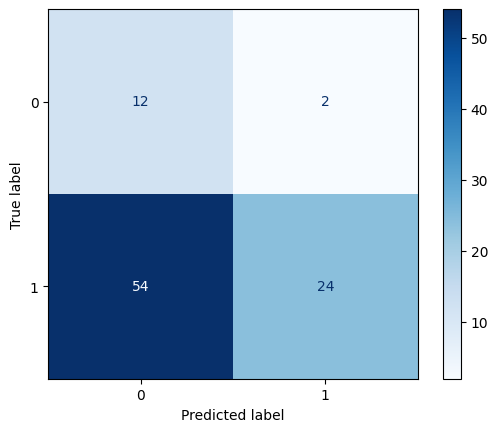

In [25]:
cm = confusion_matrix(y, y_pred)
cm_display = ConfusionMatrixDisplay(cm)
cm_display.plot(cmap=plt.cm.Blues,values_format='g')
plt.show()

## Leak

### Load and Prepare Data

In [26]:
df = pd.read_excel(os.path.join(EX_PATH, 'sample/leak.xlsx'))
df['Address'] = df['Address'].str.lower()
df = df.set_index('Address')
df.head()

,TP?
Address,
0x0290ea3c728981725689187763f6c63a68e192b8,Yes
0x054ad3cd4a66f14bf5c0de2548a53be66995a4f6,Yes
0x0566c17dc2a9efcaa2f63e04cf06a69e8fc77f60,No
0x10c8324b20b7266c445944f043f53f6a77ea0bd4,Yes
0x10cc060f6f9b2e5dcdb23f1361e4b368a7daec73,Yes


In [27]:
df.isna().sum()

TP?    0
dtype: int64

In [28]:
files = []
y = []

for path in list(Path(HEX_PATH).glob('*.hex')):
    address = path.stem.lower()
    if address in df.index:
        files.append(path)
        tp_value = df.loc[address, 'TP?']
        if isinstance(tp_value, pd.Series):
            tp_value = tp_value.iloc[0]
        y.append(1 if tp_value == 'Yes' else 0)

X = get_byte_freq_from_files(files)

100%|██████████| 87/87 [00:00<00:00, 561.95it/s]


In [29]:
X

,60,40,52,04,36,10,61,01,c2,57,...,ab,89,21,a6,b1,ba,9a,4a,e7,d5
address,,,,,,,,,,,,,,,,,,,,,
0xf6962cfe3b9618374097d51bc6691efb3974d06f,526,77,109,78,3,27,299,213,6.0,125,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0x666c549f5a01167f1aa19bb68be552441f520895,391,43,107,37,6,12,126,134,3.0,76,...,2.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
0x76bc9e61a1904b82cbf70d1fd9c0f8a120483bbb,463,37,88,67,2,20,159,194,2.0,79,...,1.0,3.0,0.0,0.0,1.0,6.0,2.0,1.0,0.0,0.0
0x10cc060f6f9b2e5dcdb23f1361e4b368a7daec73,636,98,79,119,4,19,404,240,6.0,182,...,5.0,5.0,8.0,4.0,3.0,5.0,7.0,2.0,3.0,6.0
0xa99f34b4672ff3a9837fd93dea375ccfbb83c89a,648,57,153,44,3,41,237,175,3.0,116,...,3.0,4.0,2.0,1.0,0.0,2.0,2.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0x8a52499ff8c65cedd4d7ccc283a0dab6df285fe2,706,79,170,65,9,27,257,276,1.0,106,...,1.0,5.0,2.0,2.0,1.0,1.0,2.0,1.0,0.0,5.0
0x6b9ee9e79bb893d394da79e2ea51685d1855318e,577,74,143,56,11,26,224,233,4.0,97,...,2.0,11.0,0.0,2.0,0.0,1.0,1.0,3.0,3.0,1.0
0xdf482745749ad7057f4ebe246975ff2f2ddeef78,402,46,92,43,2,10,140,151,5.0,72,...,1.0,0.0,0.0,2.0,3.0,0.0,0.0,1.0,3.0,1.0


In [30]:
y[:5]

[1, 1, 1, 1, 0]

In [31]:
X = X.reindex(columns=train_cols, fill_value=0).reset_index(drop=True)

### Evaluate

In [32]:
y_prob = model.predict(X)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [33]:
y_prob

array([[0.5253874 , 0.44715643, 0.5094842 ],
       [0.45502162, 0.5127606 , 0.48205537],
       [0.43062752, 0.47120598, 0.4924152 ],
       [0.54138994, 0.4873205 , 0.40535912],
       [0.48257113, 0.5330015 , 0.50830567],
       [0.46455815, 0.49979103, 0.4661884 ],
       [0.5400702 , 0.45029446, 0.58249146],
       [0.46621162, 0.753962  , 0.34248868],
       [0.4730986 , 0.49429333, 0.5518768 ],
       [0.52364266, 0.490205  , 0.5455239 ],
       [0.57336825, 0.5145665 , 0.44007185],
       [0.45278275, 0.43788454, 0.522528  ],
       [0.64471054, 0.6785713 , 0.22713189],
       [0.5687635 , 0.60983056, 0.44191676],
       [0.46853897, 0.5000747 , 0.47201964],
       [0.45618457, 0.43942705, 0.60630196],
       [0.47207624, 0.52068233, 0.495428  ],
       [0.49817485, 0.49229318, 0.44182757],
       [0.49090558, 0.5218493 , 0.48065388],
       [0.4617627 , 0.47931743, 0.47475675],
       [0.52338207, 0.56584185, 0.5119883 ],
       [0.6993596 , 0.770117  , 0.20464772],
       [0.

In [34]:
y_pred = (y_prob >= best_thresholds).astype(int)

In [35]:
y_pred[1]

array([0, 0, 1])

In [36]:
y_pred[:, 1]

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0])

In [37]:
y_pred = y_pred[:, 1]

In [38]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0])

In [39]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.16      0.92      0.28        13
           1       0.92      0.16      0.28        74

    accuracy                           0.28        87
   macro avg       0.54      0.54      0.28        87
weighted avg       0.81      0.28      0.28        87



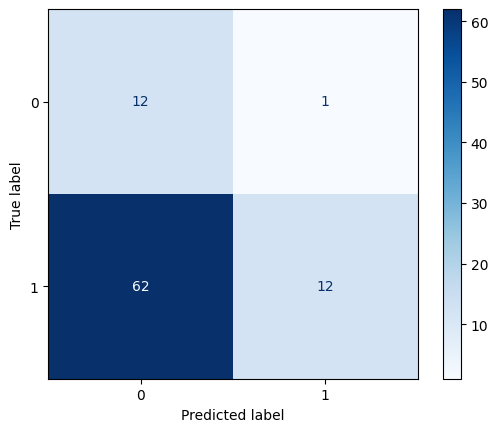

In [40]:
cm = confusion_matrix(y, y_pred)
cm_display = ConfusionMatrixDisplay(cm)
cm_display.plot(cmap=plt.cm.Blues,values_format='g')
plt.show()

## Limit

### Load and Prepare Data

In [41]:
df = pd.read_excel(os.path.join(EX_PATH, 'sample/limit.xlsx'))
df['Address'] = df['Address'].str.lower()
df = df.set_index('Address')
df.head()

,TP?
Address,
0xe5f3c6d2b47cbe2cf936b9521466bac2422ebef8,Yes
0xa623b5a542c0d7daadef321042a04c600b03a8cb,Yes
0xe412189da2dfa188a1a61633114b8732bbbfba19,Yes
0x9fcf7acdc11fd904c4b73a009909c7f00efc4844,Yes
0x921a5dce3dfed5cccfbb2e593f2978533bc66110,Yes


In [42]:
df.isna().sum()

TP?    0
dtype: int64

In [43]:
files = []
y = []

for path in list(Path(HEX_PATH).glob('*.hex')):
    address = path.stem.lower()
    if address in df.index:
        files.append(path)
        tp_value = df.loc[address, 'TP?']
        if isinstance(tp_value, pd.Series):
            tp_value = tp_value.iloc[0]
        y.append(1 if tp_value == 'Yes' else 0)

X = get_byte_freq_from_files(files)

100%|██████████| 91/91 [00:00<00:00, 656.39it/s]


In [44]:
X

,60,80,40,52,04,36,10,61,01,07,...,be,9a,d5,a6,e7,e8,f0,8e,1c,e6
address,,,,,,,,,,,,,,,,,,,,,
0x1f4a9567c1f98a8c9d7f026827f099b41a2e54d6,378,198,43,92,60,12.0,7.0,159,191,12.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0x76bc9e61a1904b82cbf70d1fd9c0f8a120483bbb,463,108,37,88,67,2.0,20.0,159,194,9.0,...,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0xa5d77efbc45d574b689d7f1202cf817e23febb97,344,149,32,91,40,3.0,7.0,142,136,7.0,...,0.0,0.0,1.0,2.0,1.0,3.0,0.0,0.0,0.0,0.0
0xb08fc1db58ef5e15a6f97d8f63b2bb4a14b9df37,169,59,23,41,21,1.0,0.0,55,73,6.0,...,1.0,1.0,2.0,0.0,0.0,0.0,6.0,1.0,0.0,0.0
0x40165bd6d657b63cb6f8f4a3525ac05bbf74bd93,596,210,64,142,51,17.0,31.0,223,182,12.0,...,2.0,0.0,1.0,2.0,1.0,0.0,0.0,3.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0x4c567c3363cc42c5a42c6d8bf01503fd1d0b91cd,512,174,60,142,52,3.0,8.0,162,230,7.0,...,1.0,0.0,4.0,1.0,0.0,2.0,1.0,1.0,0.0,1.0
0x3fb1926a7d1cc68d4166d99c3483465885074f2f,391,222,53,109,46,15.0,15.0,127,209,11.0,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
0xfb5fb992b64c86fbcb33ba151abd8ecbcc611bde,465,275,67,119,60,19.0,10.0,174,249,17.0,...,0.0,0.0,1.0,0.0,3.0,1.0,1.0,0.0,0.0,2.0


In [45]:
y[:5]

[1, 1, 1, 0, 1]

In [46]:
X = X.reindex(columns=train_cols, fill_value=0).reset_index(drop=True)

### Evaluate

In [47]:
y_prob = model.predict(X)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step 


In [48]:
y_prob

array([[0.5123036 , 0.41098803, 0.5498031 ],
       [0.43062752, 0.47120598, 0.4924152 ],
       [0.47145584, 0.52628416, 0.47169623],
       [0.52216554, 0.39590472, 0.4990878 ],
       [0.4590777 , 0.50758374, 0.5052815 ],
       [0.4823857 , 0.49479416, 0.5053115 ],
       [0.4643395 , 0.5148635 , 0.46907514],
       [0.4761747 , 0.5779678 , 0.51567423],
       [0.4615316 , 0.42913836, 0.4255275 ],
       [0.50578284, 0.4837803 , 0.46337616],
       [0.59365255, 0.52397376, 0.36464673],
       [0.45982975, 0.49221042, 0.46635237],
       [0.47109944, 0.5268408 , 0.47013637],
       [0.5759312 , 0.39630494, 0.56046027],
       [0.50309527, 0.4594134 , 0.46842226],
       [0.4635871 , 0.49933293, 0.48657393],
       [0.456019  , 0.47907838, 0.5766189 ],
       [0.53620154, 0.5061895 , 0.52450037],
       [0.4984716 , 0.53450143, 0.5106075 ],
       [0.57866675, 0.43025666, 0.56725895],
       [0.5090006 , 0.51203793, 0.49328572],
       [0.5417306 , 0.42319605, 0.56635135],
       [0.

In [49]:
y_pred = (y_prob >= best_thresholds).astype(int)

In [50]:
y_pred[1]

array([0, 0, 1])

In [51]:
y_pred[:, 2]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1])

In [52]:
y_pred = y_pred[:, 2]

In [53]:
y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1])

In [54]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.33      0.08      0.12        13
           1       0.86      0.97      0.92        78

    accuracy                           0.85        91
   macro avg       0.60      0.53      0.52        91
weighted avg       0.79      0.85      0.80        91



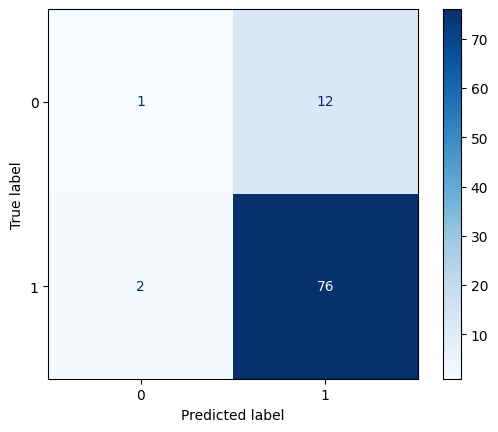

In [55]:
cm = confusion_matrix(y, y_pred)
cm_display = ConfusionMatrixDisplay(cm)
cm_display.plot(cmap=plt.cm.Blues,values_format='g')
plt.show()